In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import random
import re

Creating English character dictionary

In [3]:
print(device)

cpu


In [4]:
english_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_string = 'PAD'
english_dict = {pad_string:0}
for i,j in enumerate(english_alphabets):
    english_dict[j] = i+1
print(english_dict)

{'PAD': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


Creating Hindi character dictionary

In [5]:
Hindi_alphabets = [chr(i) for i in range(2304, 2432)]
Hindi_dict = {pad_string:0}
for i,j in enumerate(Hindi_alphabets):
     Hindi_dict[j] = i+1
print(Hindi_dict)

{'PAD': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 11

In [6]:
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

def cleanEnglishVocab(line):
    line = line.replace('-', ' ').replace(',', ' ').upper()
    # Remove all non-letters
    line = non_eng_letters_regex.sub('', line)
    return line.split()

def cleanHindiVocab(line):
    line = line.replace('-', ' ').replace(',', ' ')
    # Remove all non-Hindi chars except space
    cleaned_line = ''
    for char in line:
        if char in Hindi_dict or char == ' ':
            cleaned_line += char

    return cleaned_line.split()

In [7]:
class TransliterationDataLoader(Dataset):
    def __init__(self, filename):
        self.english_words, self.hindi_words = self.readXmlDataset(filename, cleanHindiVocab)
        self.shuffle_indices = list(range(len(self.english_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0

    def __len__(self):
        return len(self.english_words)

    def __getitem__(self, idx):
        return self.english_words[idx], self.hindi_words[idx]

    def readXmlDataset(self, filename, cleanHindiVocab):
        transliterationCorpus = ET.parse(filename).getroot()
        eng_words = []
        hd_words = []

        for line in transliterationCorpus:
            wordlist1 = cleanEnglishVocab(line[0].text)
            wordlist2 = cleanHindiVocab(line[1].text)

            # Skip noisy data
            if len(wordlist1) != len(wordlist2):
                print('Skipping: ', line[0].text, ' - ', line[1].text)
                continue

            for word in wordlist1:
                eng_words.append(word)
            for word in wordlist2:
                hd_words.append(word)

        return eng_words, hd_words

    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.english_words)))

    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []
        if end >= len(self.english_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.english_words)]]
            end = len(self.english_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]

    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.english_words)
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
        self.shuffle_start_index += batch_size + 1

        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.english_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0

        return eng_batch, hindi_batch

In [8]:
train_data = TransliterationDataLoader('/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Transliteration/Original-NEWS2012-data/Training/NEWS2012-Training-EnHi-13937.xml')
test_data = TransliterationDataLoader('/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Transliteration/Original-NEWS2012-data/Ref/NEWS2012-Ref-EnHi-1000.xml')

In [9]:
print("Train Set Size:\t", len(train_data))
print("Test Set Size:\t", len(test_data))

print('\nSample data from train-set:')
for i in range(10):
    eng, hindi = train_data.get_random_sample()
    print(eng + ' - ' + hindi)

Train Set Size:	 20641
Test Set Size:	 1000

Sample data from train-set:
QUEENSLAND - क्वीन्सलैंड
SAJNI - सजनी
GRINHAM - ग्रिनहैम
GANNAVARAM - गन्नावरम
SARWATE - शोत्री
JOEY - जॉय
STRIX - स्ट्रिक्स
GOBAIN - गॉबेन
MORNE - मॉर्न
MUSHFIQ - मुश्फीक़


In [10]:
def eng_rep(word, letter2index,device = device):
    rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos] = 1
    pad_pos = letter2index[pad_string]
    rep[letter_index+1][0][pad_pos] = 1
    return rep

def Hindi_rep(word, letter2index,device = device):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_string]
    return gt_rep

eng, hindi = train_data.get_random_sample()
english_rep = eng_rep(eng, english_dict)
print(eng, english_rep)

hindi_gt = Hindi_rep(hindi, Hindi_dict)
print(hindi, hindi_gt)


PEACE tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
पीस tensor([[43],
        [65],
        [57],
        [ 0]])


In [11]:
MAX_ENCODER_STEPS = 30
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoderAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Transliteration_EncoderDecoderAttention, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

        self.U = nn.Linear(self.hidden_size, self.hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)


    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS,  device = device,ground_truth = None):
        encoder_outputs,h_state = self.encoder_rnn_cell(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        decoder_state = h_state

        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        outputs = []
        U = self.U(encoder_outputs)

        for i in range(max_output_chars):
            W = self.W(h_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            V = self.attn(torch.tanh(U + W))
            attn_weights = F.softmax(V.view(1, -1), dim = 1)

            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)

            out, h_state= self.decoder_rnn_cell(decoder_input, h_state)
            out = self.h2o(h_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device = device)
            one_hot.scatter_(2, max_idx, 1) # In dim 2, set max_idx's as 1
            decoder_input = one_hot.detach()

        return outputs


In [12]:
def train_batch(net, opt, criterion, batch_size,device = device, teacher_force = False):
    net.train().to(device)
    opt.zero_grad()
    eng_batch, hindi_batch = train_data.get_batch(batch_size)

    total_loss = 0
    for i in range(batch_size):
        input = eng_rep(eng_batch[i], english_dict,device)
        gt = Hindi_rep(hindi_batch[i], Hindi_dict,device)
        outputs = net(input, gt.shape[0],device, ground_truth = gt if teacher_force else None)

        for index, output in enumerate(outputs):
            loss = criterion(output, gt[index]) / batch_size
            loss.backward(retain_graph = True)
            total_loss += loss

    opt.step()
    return total_loss/batch_size
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5,device = device):
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3

    loss_arr = np.zeros(n_batches + 1)

    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size,device = device, teacher_force = i<teacher_force_upto ))/(i + 1)
        if i%display_freq == display_freq-1:
            clear_output(wait=True)

            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')

    torch.save(net, 'model.pt')
    return loss_arr

In [13]:
Model = Transliteration_EncoderDecoderAttention(len(english_dict), 300, len(Hindi_dict))

Iteration 3999 Loss 0.08583437651395798


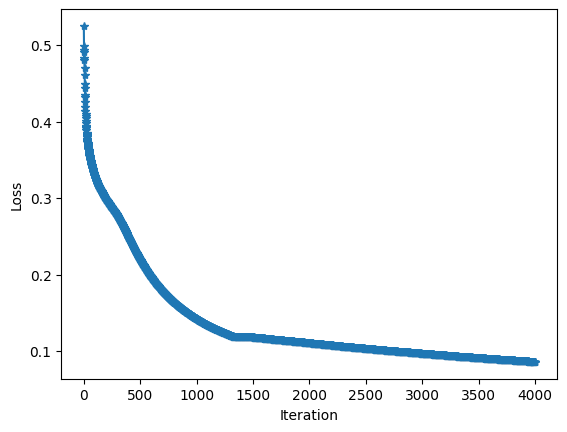

In [14]:
loss_history = train_setup(Model, lr=0.001, n_batches=4000, batch_size = 64, display_freq=10,device = device)

In [15]:
def infer(Model, word, char_limit,):
    input = eng_rep(word, english_dict)
    return Model(input, char_limit)

def test(Model, word):
    net = Model.eval()
    outputs = infer(net, word, 30)
    hindi_output = ''
    for out in outputs:
        val, indices = out.topk(1)
        index = indices.tolist()[0][0]
        if index == 0:
            break
        hindi_char = Hindi_alphabets[index+1]
        hindi_output += hindi_char
    print(word + ' - ' + hindi_output)
    return hindi_output

hindi_word = test(Model, 'PAL')

PAL - बीऴ


In [31]:
hindi_word = test(Model, 'CHIP')

CHIP - जुब


In [ ]:
def calc_accuracy(Model):
    net = Model.eval()
    predictions = []
    accuracy = 0
    for i in range(len(train_data)):
        eng, hindi = train_data[i]
        gt = Hindi_rep(hindi, Hindi_dict)
        outputs = infer(net, eng, gt.shape[0])
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            hindi_pos = indices.tolist()[0]
            if hindi_pos[0] == gt[index][0]:
                correct += 1

        accuracy += correct/gt.shape[0]
    accuracy /= len(train_data)
    return accuracy

accuracy = calc_accuracy(Model) * 100

In [35]:
print('Accuracy Train: ', accuracy)

Accuracy Train:  88.33570339925905


In [37]:
def calc_accuracy(Model):
    net = Model.eval()
    predictions = []
    accuracy = 0
    for i in range(len(test_data)):
        eng, hindi = test_data[i]
        gt = Hindi_rep(hindi, Hindi_dict)
        outputs = infer(net, eng, gt.shape[0])
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            hindi_pos = indices.tolist()[0]
            if hindi_pos[0] == gt[index][0]:
                correct += 1

        accuracy += correct/gt.shape[0]
    accuracy /= len(test_data)
    return accuracy

accuracy_Test = calc_accuracy(Model) * 100


In [38]:
print('Accuracy Test: ', accuracy_Test)

Accuracy Test:  78.27736874236876
